[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1RJVZEO7A3otz5JXsnQ5Yw0b3i6YtgoJ0?usp=sharing)

# *Preparation*
---

In [ ]:
# Install library
%%capture
!pip install transformers
!pip install scikit-plot

In [ ]:
# Import library
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
import tensorflow as tf
from tensorflow.keras import backend as K
from transformers import DistilBertTokenizerFast, DistilBertConfig, TFDistilBertModel

# *Dataset Initialization*
---

In [ ]:
# Identifikasi string punctuation dan panjang kolom pandas
string.punctuation
pd.set_option("display.max_colwidth", None)

In [ ]:
# Inisialisasi link dataset
csv_x_train_url = "https://raw.githubusercontent.com/RayWilliam46/FineTune-DistilBERT/main/data/processed/balanced_dataset/X_train_aug.csv"
csv_y_train_url = "https://raw.githubusercontent.com/RayWilliam46/FineTune-DistilBERT/main/data/processed/balanced_dataset/y_train_aug.csv"
csv_x_val_url = "https://raw.githubusercontent.com/RayWilliam46/FineTune-DistilBERT/main/data/processed/balanced_dataset/X_valid_aug.csv"
csv_y_val_url = "https://raw.githubusercontent.com/RayWilliam46/FineTune-DistilBERT/main/data/processed/balanced_dataset/y_valid_aug.csv"
csv_test_url = "https://raw.githubusercontent.com/RayWilliam46/FineTune-DistilBERT/main/data/processed/test_merged.csv"

In [ ]:
# Load training data
df_x_train = pd.read_csv(csv_x_train_url)
df_x_val = pd.read_csv(csv_x_val_url)
df_y_train = pd.read_csv(csv_y_train_url)
df_y_val = pd.read_csv(csv_y_val_url)

# Definisi variabel training data
X_train = df_x_train["comment_text"]
X_valid = df_x_val["comment_text"]
y_train = df_y_train["isToxic"]
y_valid = df_y_val["isToxic"]

# Load test data
df_test = pd.read_csv(csv_test_url)

# Definisi variabel test data
X_test = df_test["comment_text"]
y_test = df_test["isToxic"]

# Check data
print("Jumlah training data    ", len(X_train.index), " baris.")
print("Jumlah validation data  ", len(X_valid.index), " baris.")
print("Jumlah test data        ", len(X_test.index), " baris.")

Jumlah training data     97417  baris.
Jumlah validation data   24355  baris.
Jumlah test data         63978  baris.


In [ ]:
print(type(X_train))
print(type(X_valid))
print(type(y_train))
print(type(y_valid))
print(type(X_test))
print(type(y_test))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


# *Variabel and Function Definition*
---

In [ ]:
# Definisi fariabel
params = {"MAX_LENGTH": 128,
          "EPOCHS": 10,
          "LEARNING_RATE": 1e-5,
          "FT_EPOCHS": 5,
          'FT_LEARNING_RATE': 1e-6,
          "OPTIMIZER": "adam",
          "FL_GAMMA": 2.0,
          "FL_ALPHA": 0.2,
          "BATCH_SIZE": 64,
          "VERBOSE": 2,
          "NUM_STEPS": len(X_train.index) // 64,
          "DISTILBERT_DROPOUT": 0.2,
          "DISTILBERT_ATT_DROPOUT": 0.2,
          "LAYER_DROPOUT": 0.2,
          "DENSE_ACTIVATION": "tanh",
          "OUTPUT_ACTIVATION": "sigmoid",
          "DENSE_BIAS": "zeros",
          "KERNEL_INITIALIZER": "GlorotNormal",
          "BIAS_INITIALIZER": "zeros",
          "POS_PROBA_THRESHOLD": 0.5,          
          "ADDED_LAYERS": "Dense 256, Dense 128, Dense 32, Dropout 0.2",
          "LR_SCHEDULE": "1e-5 for 10 epochs, Fine-tune w/ adam for 5 epochs @1e-6",
          "FREEZING": "All DistilBERT layers frozen for 10 epochs, then unfrozen for 5",
          "RANDOM_STATE": 42,
          }

In [ ]:
# Definisi fungsi encoding
def batch_encode(tokenizer, texts, batch_size=256, max_length=params["MAX_LENGTH"]):
    input_ids = []
    attention_mask = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=max_length,
                                             padding="longest",
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_token_type_ids=False
                                             )
        print(type(inputs))
        print(type(inputs["input_ids"]))
        print(type(inputs["attention_mask"]))
        input_ids.extend(inputs["input_ids"])
        attention_mask.extend(inputs["attention_mask"])
    
    
    print(type(input_ids))
    print(type(attention_mask))
    print(type(input_ids[0]))
    print(type(attention_mask[0]))
    print(input_ids[0])
    print(attention_mask[0])
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)

# Visualisasi *dataset*
---

In [ ]:
# Fungsi menghapus tanda baca
def remove_punctuation(text):
    punctuationfree = "".join([i for i in text if i not in string.punctuation])

    return punctuationfree

In [ ]:
# Fungsi mengapus tanda unik
def remove_trailing(text):
    trailingfree1 = text.replace("\n","")
    trailingfree2 = trailingfree1.replace("\r","")
    trailingfree3 = trailingfree2.replace("\t","")
    trailingfree4 = trailingfree3.replace("—","")
    
    return trailingfree4

In [ ]:
# Fungsi menampilkan jumlah distribusi kata
def word_dist(data):
    plt.figure(figsize=(8, 8))

    sns.displot(data)

    plt.xlim(0, 1000)

    plt.xlabel("Jumlah kata ", fontsize=16)
    plt.title("Jumlah distribusi kata ", fontsize=18)
    plt.show()

<Axes: >

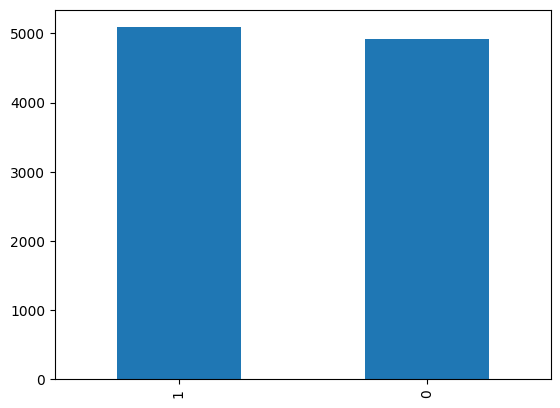

In [ ]:
# Visualisasi distribusi data training di kolom "isToxic"
df_y_train["isToxic"].value_counts().plot.bar()

In [ ]:
# Cleaning dataset x_train
df_x_train["clean_punct_comment_text"] = df_x_train["comment_text"].apply(lambda x:remove_punctuation(x))
df_x_train["clean_trail_comment_text"] = df_x_train["clean_punct_comment_text"].apply(lambda x:remove_trailing(x))
df_x_train["clean_lower_comment_text"] = df_x_train["clean_trail_comment_text"].apply(lambda x: x.lower())
df_x_train["count"] = df_x_train["clean_lower_comment_text"].apply(lambda x: len(x.split()))
df_x_train.head()

,comment_text,clean_punct_comment_text,clean_trail_comment_text,clean_lower_comment_text,count
0,"""\nThat can easily fit in the """"singles"""" section of the album article.— """,\nThat can easily fit in the singles section of the album article—,That can easily fit in the singles section of the album article,that can easily fit in the singles section of the album article,12
1,"High gravity as a substitute for high speed relatistic time dilation effect \n\nFrom the article:\n\nUsing time dilation under the Theory of General Relativity, for instance: \nResiding inside of a hollow, high-mass object; \n\nAre you sure this is accurate? I was under the impression that according to the shell theorem, the net gravity inside a hollow, symmetrical sphere was zero. If the hollow object isn't symmetrical, there could be some gravity inside, but in that case it would be no different from (and probably less efficient than) standing on the outside of a high-mass object.",High gravity as a substitute for high speed relatistic time dilation effect \n\nFrom the article\n\nUsing time dilation under the Theory of General Relativity for instance \nResiding inside of a hollow highmass object \n\nAre you sure this is accurate I was under the impression that according to the shell theorem the net gravity inside a hollow symmetrical sphere was zero If the hollow object isnt symmetrical there could be some gravity inside but in that case it would be no different from and probably less efficient than standing on the outside of a highmass object,High gravity as a substitute for high speed relatistic time dilation effect From the articleUsing time dilation under the Theory of General Relativity for instance Residing inside of a hollow highmass object Are you sure this is accurate I was under the impression that according to the shell theorem the net gravity inside a hollow symmetrical sphere was zero If the hollow object isnt symmetrical there could be some gravity inside but in that case it would be no different from and probably less efficient than standing on the outside of a highmass object,high gravity as a substitute for high speed relatistic time dilation effect from the articleusing time dilation under the theory of general relativity for instance residing inside of a hollow highmass object are you sure this is accurate i was under the impression that according to the shell theorem the net gravity inside a hollow symmetrical sphere was zero if the hollow object isnt symmetrical there could be some gravity inside but in that case it would be no different from and probably less efficient than standing on the outside of a highmass object,94
2,"god pisses off go piss of butt, now just know that you just heard me that i will use a fork to take and destroy the eyes and take out your fuckin! blood, so just piss off butt, piss off but, i said piss off butt, last chance : piss off butt!, that's it, i will kill you, pow, so see that, you are dead and i will stab you now, penis, dick, boobs, breasts, poo.",god pisses off go piss of butt now just know that you just heard me that i will use a fork to take and destroy the eyes and take out your fuckin blood so just piss off butt piss off but i said piss off butt last chance piss off butt thats it i will kill you pow so see that you are dead and i will stab you now penis dick boobs breasts poo,god pisses off go piss of butt now just know that you just heard me that i will use a fork to take and destroy the eyes and take out your fuckin blood so just piss off butt piss off but i said piss off butt last chance piss off butt thats it i will kill you pow so see that you are dead and i will stab you now penis dick boobs breasts poo,god pisses off go piss of butt now just know that you just heard me that i will use a fork to take and destroy the eyes and take out your fuckin blood so just piss off butt piss off but i said piss off butt last chance piss off butt thats it i will kill you pow so see that you are dead an

In [ ]:
# Drop kolom
df_x_train = df_x_train.drop(columns=["comment_text", "clean_punct_comment_text", "clean_trail_comment_text"])
df_x_val = df_x_val.drop(columns=["comment_text", "clean_punct_comment_text", "clean_trail_comment_text"])
df_test = df_test.drop(columns=["comment_text", "clean_punct_comment_text", "clean_trail_comment_text"])

In [ ]:
# Rename kolom
df_x_train.rename(columns = {"clean_lower_comment_text":"comment_text"}, inplace = True)
df_x_val.rename(columns = {"clean_lower_comment_text":"comment_text"}, inplace = True)
df_test.rename(columns = {"clean_lower_comment_text":"comment_text"}, inplace = True)

<Figure size 800x800 with 0 Axes>

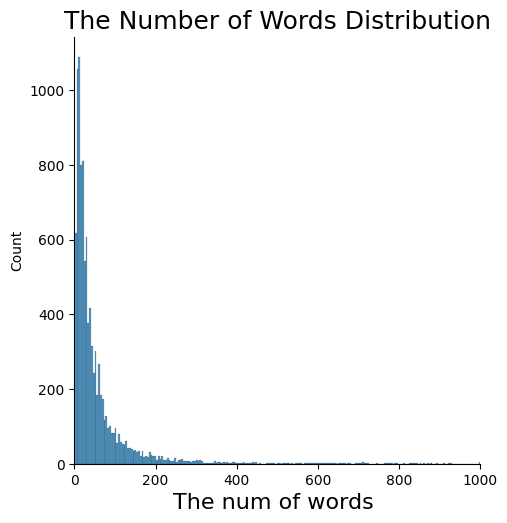

In [ ]:
# Menampilkan jumlah distribusi kata x_train
word_dist(df_x_train["count"])

In [ ]:
# Menampilkan dataset x_train
df_x_train.head()

,comment_text,count
0,that can easily fit in the singles section of the album article,12
1,high gravity as a substitute for high speed relatistic time dilation effect from the articleusing time dilation under the theory of general relativity for instance residing inside of a hollow highmass object are you sure this is accurate i was under the impression that according to the shell theorem the net gravity inside a hollow symmetrical sphere was zero if the hollow object isnt symmetrical there could be some gravity inside but in that case it would be no different from and probably less efficient than standing on the outside of a highmass object,94
2,god pisses off go piss of butt now just know that you just heard me that i will use a fork to take and destroy the eyes and take out your fuckin blood so just piss off butt piss off but i said piss off butt last chance piss off butt thats it i will kill you pow so see that you are dead and i will stab you now penis dick boobs breasts poo,75
3,actions speak louder than words commodore you can show that you are there to contribute by actually contributingmaking the definition better,21
4,even knowledgeable and experienced neutral editors,6


# *Preprocessing*
---

In [ ]:
# Inisialisasi token distilBERT
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Encode X_train
X_train_ids, X_train_attention = batch_encode(tokenizer, X_train.tolist())

# # Encode X_valid
X_valid_ids, X_valid_attention = batch_encode(tokenizer, X_valid.tolist())

# Encode X_test
X_test_ids, X_test_attention = batch_encode(tokenizer, X_test.tolist())

<class 'transformers.tokenization_utils_base.BatchEncoding'>
<class 'list'>
<class 'list'>
<class 'transformers.tokenization_utils_base.BatchEncoding'>
<class 'list'>
<class 'list'>
<class 'transformers.tokenization_utils_base.BatchEncoding'>
<class 'list'>
<class 'list'>
<class 'transformers.tokenization_utils_base.BatchEncoding'>
<class 'list'>
<class 'list'>
<class 'transformers.tokenization_utils_base.BatchEncoding'>
<class 'list'>
<class 'list'>
<class 'transformers.tokenization_utils_base.BatchEncoding'>
<class 'list'>
<class 'list'>
<class 'transformers.tokenization_utils_base.BatchEncoding'>
<class 'list'>
<class 'list'>
<class 'transformers.tokenization_utils_base.BatchEncoding'>
<class 'list'>
<class 'list'>
<class 'transformers.tokenization_utils_base.BatchEncoding'>
<class 'list'>
<class 'list'>
<class 'transformers.tokenization_utils_base.BatchEncoding'>
<class 'list'>
<class 'list'>
<class 'transformers.tokenization_utils_base.BatchEncoding'>
<class 'list'>
<class 'list'>

In [ ]:
type(X_test_ids)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
X_test_ids[0]

<tf.Tensor: shape=(128,), dtype=int32, numpy=
array([ 101, 4067, 2017, 2005, 4824, 1012, 1045, 2228, 2200, 3811, 1997,
       2017, 1998, 2052, 2025, 7065, 8743, 2302, 6594, 1012,  102,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], dtype=int32)>

# *Build Model*
---

In [ ]:
# Definisi fungsi loss
# Kode didapat dari https://gist.github.com/mkocabas/62dcd2f14ad21f3b25eac2d39ec2cc95
def focal_loss(gamma=params["FL_GAMMA"], alpha=params["FL_ALPHA"]):
    
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    
    return focal_loss_fixed

In [ ]:
# Fungsi custom model
def build_model(transformer, max_length=params["MAX_LENGTH"]):
    
    # Definisi bobot
    weight_initializer = tf.keras.initializers.GlorotNormal(seed=params["RANDOM_STATE"]) 
    
    # Definisi layers input
    input_ids_layer = tf.keras.layers.Input(shape=(max_length,), 
                                            name="input_ids", 
                                            dtype="int32",
                                            )
    input_attention_layer = tf.keras.layers.Input(shape=(max_length,), 
                                                  name="input_attention", 
                                                  dtype="int32",
                                                  )
    # Output model DistilBERT berbentuk tuple dengan elemen di index ke 0 adalah
    # representasi hidden-state output dari model layer terakhir
    # dengan sebuah tf.Tensor dengan ukuran (batch_size, sequence_length, hidden_size=768).
    last_hidden_state = transformer([input_ids_layer, input_attention_layer])[0]
    
    # Kami akan menggunakan output DistilBERT untuk token [CLS] yang berlokasi di index 0.
    # Sehingga kami akan melakukan Splicing token [CLS] yang memberikan sebuah data 2D.
    cls_token = last_hidden_state[:, 0, :]
    
    D1 = tf.keras.layers.Dropout(params["LAYER_DROPOUT"],
                                 seed=params["RANDOM_STATE"],
                                 name="Dropout_1",
                                )(cls_token)
    
    Dense1 = tf.keras.layers.Dense(256,
                                   activation=params["DENSE_ACTIVATION"],
                                   kernel_initializer=weight_initializer,
                                   bias_initializer=params["DENSE_BIAS"],
                                   name="Dense_1",
                                  )(D1)
    
    D2 = tf.keras.layers.Dropout(params["LAYER_DROPOUT"],
                                 seed=params["RANDOM_STATE"],
                                 name="Dropout_2",
                                )(Dense1)
    
    Dense2 = tf.keras.layers.Dense(128,
                                   activation=params["DENSE_ACTIVATION"],
                                   kernel_initializer=weight_initializer,
                                   bias_initializer=params["DENSE_BIAS"],
                                   name="Dense_2",
                                  )(D2)
    
    D3 = tf.keras.layers.Dropout(params["LAYER_DROPOUT"],
                                 seed=params["RANDOM_STATE"],
                                 name="Dropout_3",
                                )(Dense2)

    Dense3 = tf.keras.layers.Dense(32,
                                   activation=params["DENSE_ACTIVATION"],
                                   kernel_initializer=weight_initializer,
                                   bias_initializer=params["DENSE_BIAS"],
                                   name="Dense_3",
                                  )(D3)

    D4 = tf.keras.layers.Dropout(params["LAYER_DROPOUT"],
                                 seed=params["RANDOM_STATE"],
                                 name="Dropout_4",
                                )(Dense3)
                                
    output = tf.keras.layers.Dense(1, 
                                   activation=params["OUTPUT_ACTIVATION"],
                                   kernel_initializer=weight_initializer,
                                   bias_initializer=params["DENSE_BIAS"],
                                   name="Output",
                                  )(D4)
    
    # Definisi model
    model = tf.keras.Model([input_ids_layer, input_attention_layer], output)
    
    # Compile model
    model.compile(tf.keras.optimizers.Adam(learning_rate=params["LEARNING_RATE"]), 
                  loss=focal_loss(),
                  metrics=["accuracy"],
                 )
    
    return model

In [ ]:
# Konfigurasi model DistilBERT
config = DistilBertConfig(dropout=params["DISTILBERT_DROPOUT"], 
                          attention_dropout=params["DISTILBERT_ATT_DROPOUT"], 
                          output_hidden_states=True,
                         )

# Inisialisasi model DistilBERT
distilBERT = TFDistilBertModel.from_pretrained("distilbert-base-uncased", config=config)

# Membekukan layer di model DistilBERT untuk mempertahankan bobot yang telah dilatih sebelumnya
for layer in distilBERT.layers:
    layer.trainable = False

# Build model
model = build_model(distilBERT)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
# Training model
train_history = model.fit(
    x = [X_train_ids, X_train_attention],
    y = y_train.to_numpy(),
    epochs = params["EPOCHS"],
    batch_size = params["BATCH_SIZE"],
    steps_per_epoch = params["NUM_STEPS"],
    validation_data = ([X_valid_ids, X_valid_attention], y_valid.to_numpy()),
    verbose=params["VERBOSE"],
)

Epoch 1/10
1522/1522 - 523s - loss: 0.0657 - accuracy: 0.6492 - val_loss: 0.0349 - val_accuracy: 0.7810 - 523s/epoch - 344ms/step
Epoch 2/10
1522/1522 - 515s - loss: 0.0434 - accuracy: 0.7687 - val_loss: 0.0335 - val_accuracy: 0.8094 - 515s/epoch - 338ms/step
Epoch 3/10
1522/1522 - 514s - loss: 0.0398 - accuracy: 0.7905 - val_loss: 0.0341 - val_accuracy: 0.8052 - 514s/epoch - 338ms/step
Epoch 4/10
1522/1522 - 514s - loss: 0.0378 - accuracy: 0.7987 - val_loss: 0.0340 - val_accuracy: 0.8067 - 514s/epoch - 338ms/step
Epoch 5/10
1522/1522 - 514s - loss: 0.0370 - accuracy: 0.8031 - val_loss: 0.0336 - val_accuracy: 0.8069 - 514s/epoch - 338ms/step
Epoch 6/10
1522/1522 - 514s - loss: 0.0359 - accuracy: 0.8087 - val_loss: 0.0334 - val_accuracy: 0.8066 - 514s/epoch - 338ms/step
Epoch 7/10
1522/1522 - 514s - loss: 0.0356 - accuracy: 0.8070 - val_loss: 0.0340 - val_accuracy: 0.8021 - 514s/epoch - 338ms/step
Epoch 8/10
1522/1522 - 514s - loss: 0.0350 - accuracy: 0.8099 - val_loss: 0.0315 - val_acc

# *Fine-Tuning*
---

In [ ]:
# Membuka bobot layer model DistilBERT untuk dilakukan fine-tuning
for layer in distilBERT.layers:
    layer.trainable = True

# Definisi optimizer untuk fine-tuning
optimizer = tf.keras.optimizers.Adam(learning_rate=params["FT_LEARNING_RATE"])

# Compile model
model.compile(optimizer=optimizer, 
              loss=focal_loss(),
              metrics=["accuracy"],
             )

In [ ]:
# Fine-tuning model
finetuning_history = model.fit(
    x = [X_train_ids, X_train_attention],
    y = y_train.to_numpy(),
    epochs = params["FT_EPOCHS"],
    batch_size = params["BATCH_SIZE"],
    steps_per_epoch = params["NUM_STEPS"],
    validation_data = ([X_valid_ids, X_valid_attention], y_valid.to_numpy()),
    verbose=params["VERBOSE"],
)

Epoch 1/5
1522/1522 - 1256s - loss: 0.0287 - accuracy: 0.8504 - val_loss: 0.0243 - val_accuracy: 0.8746 - 1256s/epoch - 825ms/step
Epoch 2/5
1522/1522 - 1231s - loss: 0.0241 - accuracy: 0.8772 - val_loss: 0.0215 - val_accuracy: 0.8998 - 1231s/epoch - 809ms/step
Epoch 3/5
1522/1522 - 1231s - loss: 0.0223 - accuracy: 0.8876 - val_loss: 0.0206 - val_accuracy: 0.9056 - 1231s/epoch - 809ms/step
Epoch 4/5
1522/1522 - 1229s - loss: 0.0209 - accuracy: 0.8944 - val_loss: 0.0200 - val_accuracy: 0.9108 - 1229s/epoch - 808ms/step
Epoch 5/5
1522/1522 - 1230s - loss: 0.0199 - accuracy: 0.9003 - val_loss: 0.0189 - val_accuracy: 0.9139 - 1230s/epoch - 808ms/step


# *Evaluation*
---

In [ ]:
# Evaluasi
eval_loss, eval_accuracy = model.evaluate([X_test_ids, X_test_attention],
                                          y_test.to_numpy(),
                                          batch_size=params["BATCH_SIZE"],
                                          verbose=params["VERBOSE"],
                                         )
print("Loss:", eval_loss)
print("Accuracy:", eval_accuracy)

1000/1000 - 262s - loss: 0.0601 - accuracy: 0.8995 - 262s/epoch - 262ms/step
Loss: 0.06012924388051033
Accuracy: 0.8995435833930969


# *Prediction*
----

In [ ]:
# Cek salah satu nilai prediksi
print("Nilai token X ids:")
print(X_test_ids[20:40])
print("Nilai token X attention:")
print(X_test_attention[20:40])
print("Nilai y:")
print(y_test.to_numpy()[20:40])

Nilai token X ids:
tf.Tensor(
[[ 101 1000 1027 ... 2019 5448  102]
 [ 101 1027 1027 ...    0    0    0]
 [ 101 1045 1005 ...    0    0    0]
 ...
 [ 101 1000 1024 ...    0    0    0]
 [ 101 2129 8108 ...    0    0    0]
 [ 101 9779 2361 ...    0    0    0]], shape=(20, 128), dtype=int32)
Nilai token X attention:
tf.Tensor(
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]], shape=(20, 128), dtype=int32)
Nilai y:
[0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0]


In [ ]:
# Prediksi
pred = model.predict([X_test_ids[20:40], X_test_attention[20:40]])
print("Probabilitas prediksi:", pred)
classes = np.where(pred >= params["POS_PROBA_THRESHOLD"], 1, 0)
print("Hasil prediksi di kelas: ", classes)

1/1 [==============================] - 0s 142ms/step
Probabilitas prediksi: [[0.07685834]
 [0.04424284]
 [0.13353974]
 [0.03680823]
 [0.95064515]
 [0.04203176]
 [0.04443111]
 [0.91311663]
 [0.05126998]
 [0.955203  ]
 [0.20657456]
 [0.07655811]
 [0.20705996]
 [0.08667107]
 [0.08031459]
 [0.04804233]
 [0.06772026]
 [0.30448115]
 [0.8070159 ]
 [0.28049725]]
Hasil prediksi di kelas:  [[0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]]


# *Evaluation visualization*
---

In [ ]:
# Membuat dataset history
history_train = pd.DataFrame(train_history.history)
history_finetuning = pd.DataFrame(finetuning_history.history)
history = pd.concat([history_train, history_finetuning], ignore_index=True)

Minimal Train Loss: 0.0199
Minimal Validation Loss: 0.0189


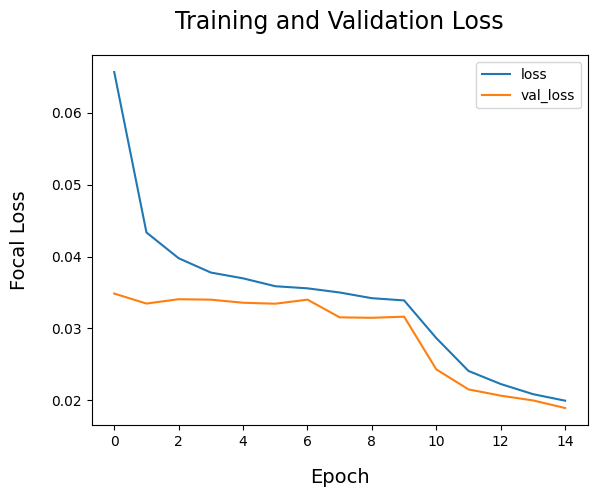

In [ ]:
# Ploting loss training dan validation setiap epoch
history.loc[:, ["loss", "val_loss"]].plot()
plt.title(label="Training and Validation Loss", fontsize=17, pad=19)
plt.xlabel("Epoch", labelpad=14, fontsize=14)
plt.ylabel("Focal Loss", labelpad=16, fontsize=14)
print("Minimal Train Loss: {:0.4f}".format(history["loss"].min()))
print("Minimal Validation Loss: {:0.4f}".format(history["val_loss"].min()))

# Menyimpan gambar
plt.savefig("balanced_trainvalloss.png", dpi=300.0, transparent=True)

Maksimal Train Accuracy: 0.9003
Maksimal Validation Accuracy: 0.9139


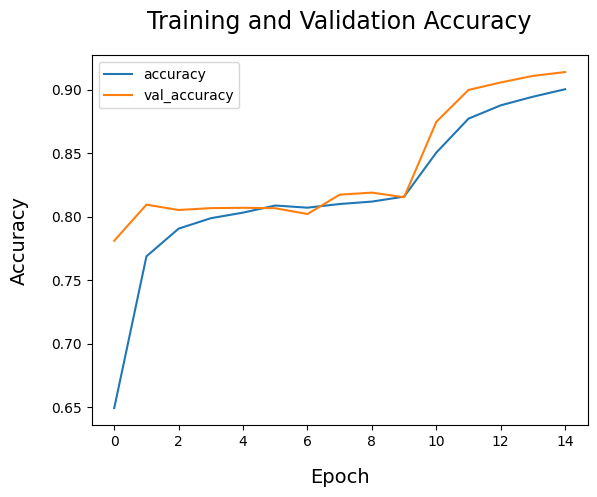

In [ ]:
# Ploting accuracy training dan validation setiap epoch
history.loc[:, ["accuracy", "val_accuracy"]].plot()
plt.title(label="Training and Validation Accuracy", fontsize=17, pad=19)
plt.xlabel("Epoch", labelpad=14, fontsize=14)
plt.ylabel("Accuracy", labelpad=16, fontsize=14)
print("Maksimal Train Accuracy: {:0.4f}".format(history["accuracy"].max()))
print("Maksimal Validation Accuracy: {:0.4f}".format(history["val_accuracy"].max()))

# Menyimpan gambar
plt.savefig("balanced_trainvalacc.png", dpi=300.0, transparent=True)

2000/2000 [==============================] - 264s 132ms/step


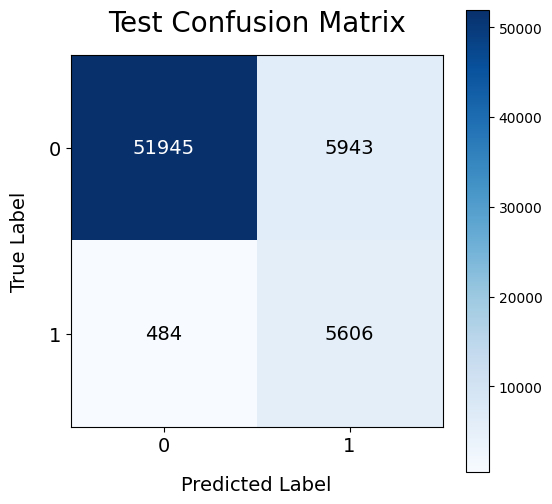

In [ ]:
# Prediksi dataset test
y_pred = model.predict([X_test_ids, X_test_attention])
y_pred_thresh = np.where(y_pred >= params["POS_PROBA_THRESHOLD"], 1, 0)

# Plot confusion matrix
skplt.metrics.plot_confusion_matrix(y_test.to_list(),
                                    y_pred_thresh.tolist(),
                                    figsize=(6, 6),
                                    text_fontsize=14,
                                   )
plt.title(label="Test Confusion Matrix", fontsize=20, pad=17)
plt.xlabel("Predicted Label", labelpad=14)
plt.ylabel("True Label", labelpad=14)

# Menyimpan gambar
plt.savefig("balanced_confusion_matrix.png", dpi=300.0, transparent=True)

# *Saving Model*
---

In [ ]:
tf.saved_model.save(model, "balanced_model.h5")

In [ ]:
model.save_weights("model_balance")

In [ ]:
import pickle

pickle.dump(model, open('model.pkl', 'wb'))

/usr/local/lib/python3.9/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [ ]:
model.save("balanced_model2.h5")

In [ ]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)